# Libraries

In [2]:
import pandas_datareader as pdr
import datetime
import pandas as pd
import numpy as np
from numpy.linalg import inv
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Data

In [2]:
stock_names = ['AAPL', 'AMZN', 'BAC', 'GOOG', 'TSLA']
start = datetime.datetime(2019, 1, 1)
end = datetime.datetime(2020, 7, 1)
stocks = pdr.DataReader(stock_names, 'yahoo',start,end)

# Graph

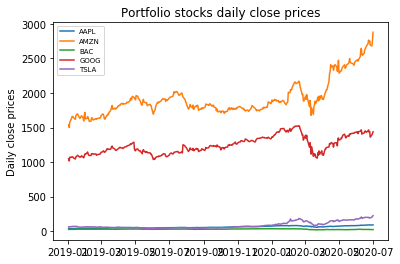

In [26]:
plt.plot(stocks.Close)
plt.legend(['AAPL', 'AMZN', 'BAC', 'GOOG', 'TSLA'], loc = 'upper left', fontsize = 7)
plt.title('Portfolio stocks daily close prices')
plt.ylabel('Daily close prices')
plt.show()

# Daily Returns

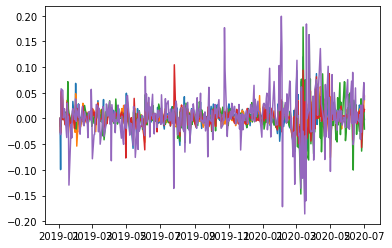

In [4]:
daily_return = stocks.Close.pct_change()
daily_return.iloc[0, :] = 0
plt.plot(daily_return)

# Base 100

In [5]:
stocks_100 = np.ones([len(stocks), 5])*100
returns_100 = np.asarray(daily_return)

for i in range(len(stocks)-1):
    stocks_100[i+1] = stocks_100[i] * (returns_100[i+1]+1)
    i += 1 
stocks_100 = pd.DataFrame(stocks_100, index=stocks.Close.index, columns=stock_names)

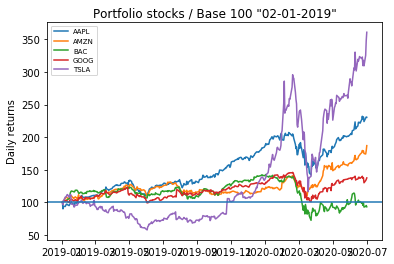

In [43]:
plt.plot(stocks_100)
plt.axhline(y=100)
plt.legend(stocks_100.columns, loc = 'upper left', fontsize = 7)
plt.title('Portfolio stocks / Base 100 "02-01-2019"')
plt.ylabel('Daily returns')
plt.show()
plt.close()

# Portfolio

In [8]:
weights= []
for i in stock_names:
    locals()["weight_"+i]=1/len(stock_names)
    weights.append(locals()["weight_"+i])
weights = np.array([weights])

In [9]:
def get_portfolio(daily_return, weights):
    Portfolio = np.empty([len(daily_return), 1])
    daily_return = np.asarray(daily_return)
    for i in range(len(stocks.Close)):
        Portfolio[i] = np.dot(daily_return[i], weights.T)
        i += 1
    return Portfolio

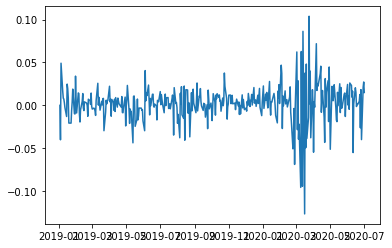

In [10]:
portfolio = get_portfolio(returns_100, weights)
portfolio = pd.DataFrame(portfolio, index = stocks.Close.index, columns = ['Portfolio'])
plt.plot(portfolio)
plt.show()
plt.close()

# Matrices

In [11]:
risk_free = 0.02
initial_weights = np.array([1/5,1/5,1/5,1/5,1/5])
#Matrix of returns
Returns_Matrix = np.array(daily_return[1:].mean(axis=0)).reshape(-1,1)
expected_return = Returns_Matrix.mean()
#Covariance matrix
covariance_matrix = np.array(daily_return[1:].cov())
# Ones vector
ones = np.ones((Returns_Matrix.shape[0],1))
zeros = np.zeros((2,2))

In [12]:
# Matrix A
A = 2*covariance_matrix
A = np.append(A, Returns_Matrix.T, axis=0)
A = np.append(A, ones.T, axis=0)
temp = np.append(Returns_Matrix, ones, axis=1)
temp = np.append(temp, zeros, axis=0)
A = np.append(A, temp, axis=1)

# Vector b
b = np.array([[0], [0], [0],[0], [0], [2.0],[1]])

In [ ]:
print(pd.DataFrame(covariance_matrix, columns = daily_return.columns, index=daily_return.columns))

# Optimization

In [13]:
#Results matrix
optimization_lagrange = inv(A)@b
optimal_weights = optimization_lagrange[:daily_return[1:].shape[1]]
#Percentages
total_invested = abs(optimal_weights).sum()
percentages = optimal_weights/total_invested # The absolute value of the percentages will sum 1

print(pd.DataFrame(percentages*100, index=daily_return[1:].columns, columns=['Optimal Weights']))
optimal_return = percentages.T@Returns_Matrix*len(daily_return[1:])
optimal_risk = np.dot(percentages.T, np.dot(covariance_matrix*len(daily_return[1:]), percentages)) 
optimal_risk = np.sqrt(optimal_risk)
print('rf is: ', 2.0, 'risk is: ', optimal_risk[0][0]*100)

         Optimal Weights
Symbols                 
AAPL           40.347383
AMZN           -0.052660
BAC           -20.533756
GOOG          -29.387006
TSLA            9.679195
rf is:  2.0 risk is:  14.832039685234516


# Backtesting

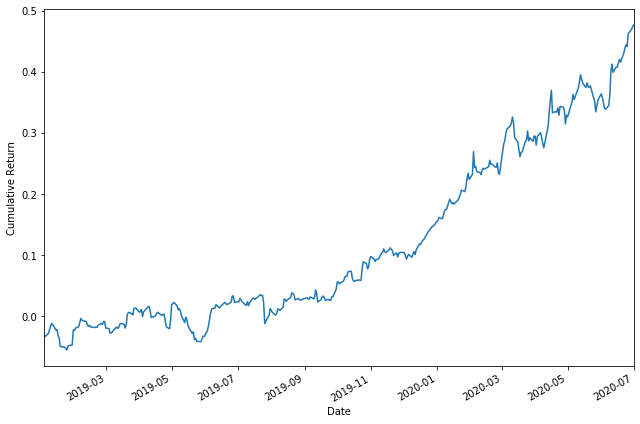

In [14]:
backtesting = pd.concat([daily_return[1:], daily_return[1:]@percentages], axis=1)
backtesting.rename({0: 'Optimal Portfolio'}, axis=1, inplace=True)
ax = ((backtesting["Optimal Portfolio"]+1).cumprod()-1).plot(kind='line', figsize=(9,6));
ax.set_ylabel('Cumulative Return')
plt.tight_layout()
plt.savefig('optimized_portfolio', bpi=150)

# Simulations and Sharpe

In [15]:
simulations = 15000
all_weights = np.zeros((simulations, 5))

rets = np.zeros(simulations)
vols = np.zeros(simulations)
sharpe_arr = np.zeros(simulations)

for i in range(simulations): 
    weights = np.array(np.random.randn(5)) 
    weights = weights/np.sum(abs(weights))  
    
    all_weights[i,:] = weights
    
    rets[i] = np.sum((daily_return.mean()*weights)*252)

    vols[i] = np.sqrt(np.dot(weights.T,np.dot(daily_return.cov()*252, weights)))

    sharpe_arr[i] = rets[i]-2.0/vols[i]

In [16]:
print('Maximum Sharpe: ', sharpe_arr.max())
print('weights of maximum sharpe: ', all_weights[sharpe_arr.argmax(), :])

Maximum Sharpe:  1.93816614465841
weights of maximum sharpe:  [0.43038819 0.27079165 0.00576122 0.03646658 0.25659236]


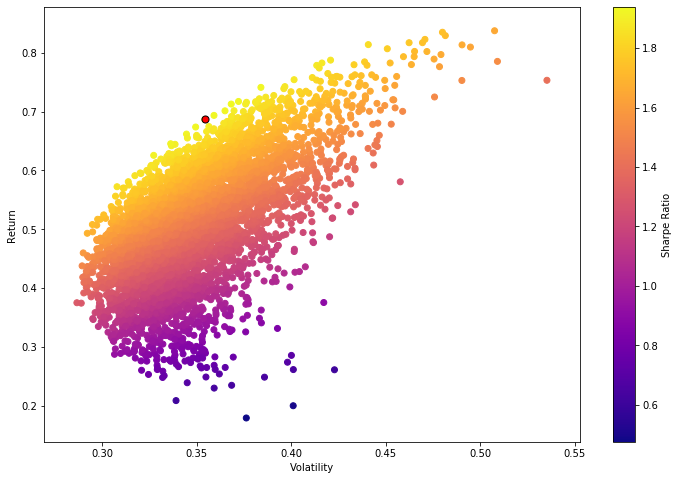

In [17]:
plt.figure(figsize=(12,8))
plt.scatter(vols,rets,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(vols[sharpe_arr.argmax()],rets[sharpe_arr.argmax()],c='red',s=50, edgecolors='black')

# Backtesting

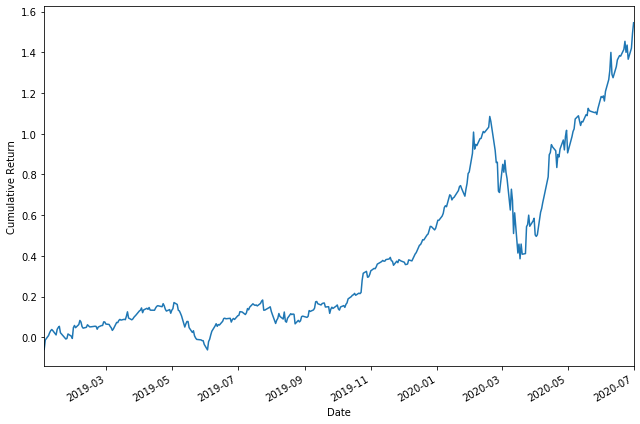

In [18]:
backtesting2 = pd.concat([daily_return[1:], daily_return[1:]@all_weights[sharpe_arr.argmax(), :]], axis=1)
backtesting2.rename({0: 'Optimal Portfolio'}, axis=1, inplace=True)
ax2 = ((backtesting2["Optimal Portfolio"]+1).cumprod()-1).plot(kind='line', figsize=(9,6));
ax2.set_ylabel('Cumulative Return')
plt.tight_layout()
plt.savefig('optimized_portfolio', bpi=150)

# Overlapping graphs

Text(0.5, 0, 'Period')

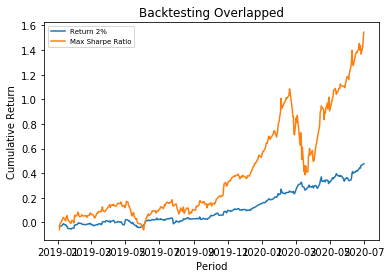

In [19]:
plt.plot(((backtesting["Optimal Portfolio"]+1).cumprod()-1))
plt.plot(((backtesting2["Optimal Portfolio"]+1).cumprod()-1))
plt.legend(["Return 2%", "Max Sharpe Ratio"], loc="upper left", fontsize=7)
plt.title("Backtesting Overlapped")
plt.ylabel("Cumulative Return")
plt.xlabel("Period")